# CMPE 252, Section 01, HW2 - SPRING 2024


## Topic: Sequential decision making with discrete state and action spaces.

In this assignment, you will solve MDP by **Value Iteration** and **Policy Iteration**
algorithms with a known dynamics and reward, $T$ and $R$, respectively. 

The assignment has 2 parts. In Part-1, you are asked to fill in the blanks in the given code, and to complete the given tasks. In Part-2, you are asked to implement the Policy Iteration algorithm using tensor broadcasting (no for loops).

You can work in teams of 2 students. Please assign yourselves to the teams on Canvas.

You can discuss your solutions with other teams, but sharing your code or parts of it with other teams is plagiarism.

What to submit on Canvas: 1) a working notebook with the full solution, and 2) its corresponding PDF. 


Due date : March 22, 2024, 11:59PM 



# <h1><center> Part-1 </center></h1>

#### Import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime
import random
import math
from tqdm import tqdm
import einops
%matplotlib inline
np.random.seed(0)
random.seed(0)

In [2]:
main_start_time = datetime.datetime.now()

<font color='red'>
You can use your maze from HW1. Make sure that there are multiple paths (at least 3) from the START = 'top left corner' to GOAL='bottom right corner'. If you do not have at least 3 paths, update your maze accordingly
</font>

#### Design a maze:

In [3]:
def get_maze(maze_file):
    '''
    para1: filename of the maze txt file
    return mazes as a numpy array walls: 0 - no wall, 1 - wall
    '''
    a = open(maze_file, 'r')  
    m=[]
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))
    return np.array(m)

In [4]:
# State Space
S=get_maze("my_maze.txt")  
START = (0, 0) # starting from TOP LEFT changing (1, 1) to (0, 0)
GOAL = (25,25)
# GOAL = (2, 2)
# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]


# Noise
ALPHA = [0.2, 0.8]

max_it = 100

In [5]:
GRID_SIZE = len(S)
# goal state
S[GOAL] = 3

#### Visualize the maze:

In [6]:
print(S)

[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1]
 [1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1]
 [1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1]
 [1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1]
 [1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1]
 [1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1]
 [1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1]
 [1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1]
 [1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1]
 [1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1]
 [1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1]
 [1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1]
 [1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1]
 [1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1]
 [1 1 1 1 

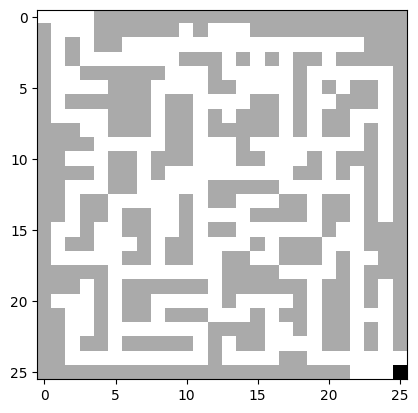

In [7]:
plt.imshow(S, cmap='binary')

#### Define a utility function, s_next_calc, which computes the index of the next state given current state and action:

In [8]:
def s_next_calc(s, a, return_actual=False):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: action taken by the agent
    : returns: New state coordinates in the grid
    '''

    if hit_wall(s, a) and not return_actual:
        return s
    return  (s[0] + A[a][0], s[1] + A[a][1])

#### Define a utility function to check if the action at current state leads to a collision with a wall:

In [9]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls. Agent calculates "hitting the wall"
    with deterministic dynamics
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE-1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==0 and S[s_new]==1):
        return True

    return False

#### Define the reward function:

In [10]:
def R(s, a):
    '''Reward function
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -10000
    else:
        return -1

#### Calculate the transition probabilities to state s_next from current state s upon action a:

In [11]:
def Pr(s_next, s, a, alpha):
    '''This function returns probabilities for each action at agent's
    current state.
    :param s: Current state of the agent
    :param a: Action the agent takes at the current state
    :param alpha: Probability of the agent to take a random action instead of the action a
    :returns : Transition probability for the action at current state
    '''
    # can't move once reached the GOAL
    if s == GOAL:
        if s_next == s:
            return 1
        else:
            return 0

    # # If wall hit, next state is current state 
    # if hit_wall(s, a):
    #     # Legal action with s = s'
    #     if s_next == s:
    #         return 1
    #     # Illegal action with s != s'
    #     else:
    #         return 0

    # Legal action with adjacent s and s'
    if s_next == s_next_calc(s, a, return_actual=True):
        return 1 - alpha
    else:
        # Agent moves to another adjacent state instead of s' due to noise in a.
        # Generate all other neighbors of s by applying actions other than a.
        other_s_next = [s_next_calc(s, i, return_actual=True)
                    for i in range(len(A)) if i is not a]
        
               
        if s_next in other_s_next:
            return alpha/4
        else:
            print(s_next, other_s_next)
    return 0

## Policy Iteration

In policy iteration, we define three functions:

* policy_evaluation
* policy_improvement
* policy_iteration

Refer to the lecture slides on policy iteration and value iteration. 

In [12]:
def policy_evaluation(policy, S, Pr, alpha, discount, theta, ctr):
    
    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
 
    for _ in range(ctr):
        # chose an initial delta value for the convergence test
        delta = 0
        V_prev = V.copy()
        for s, idx in np.ndenumerate(S):
            
            # action by the policy
            a = policy[s]
            # update value function for the state s  
            V[s] = R(s, a) + discount * np.sum([Pr(s_next_calc(s, a_ind, return_actual=True), s, a, alpha) * V_prev[s_next_calc(s, a_ind, return_actual=False)] for a_ind in range(len(A))], axis=0)
            delta = max(delta, abs(V[s] - V_prev[s]))
                            
        if delta < theta: break
    
    return V, delta

In [13]:
def policy_improvement(V, S, A, Pr, alpha, discount):
    
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    policy_stable = True
        
    for s, _ in np.ndenumerate(S):
            
        old_action = policy[s]
        Q = np.zeros(len(A))
        for a in range(len(A)):
            # update Q function at state, s, and action, a
            Q[a] = R(s, a) + discount * np.sum([Pr(s_next_calc(s, a_ind, return_actual=True), s, a, alpha) * V[s_next_calc(s, a_ind, return_actual=False)] for a_ind in range(len(A))], axis=0)
        # update policy at state s # keeping this out of for loop
        policy[s] = np.argmax(Q)

        if old_action != policy[s]: policy_stable = False
    
    return policy, policy_stable

In [14]:
def policy_iteration(S, A, Pr, alpha, discount, theta, n_eval, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise 
    :param float discount: discount factor
    :param float theta: tolerance, which determines when to end iterations
    :param int n_eval: number of evaluations
    :param plot: list of iteration numbers to plot
    """
    
    epsilon = 0
    
    # For Task 4 ######
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ###################
    
    plt.ion()
    policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))
    count=0
    
    while True:
                
        start_time = datetime.datetime.now() # For Task 4
        
        V, delta = policy_evaluation(policy, S, Pr, alpha, discount, theta, n_eval)
        policy , policy_stable = policy_improvement(V, S, A, Pr, alpha, discount)
        # print(f"Delta: {delta} -- Policy Stable: {policy_stable}")
        
        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time
      

        # plot intermediate result
        if (plot and count+1 in plot) and plot_enable:
            print(1)
            plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
        
        if delta == 0:
            print(2)
            if plot_enable :
                plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
                
        if (delta > 0 and delta<=epsilon) or count==max_it or policy_stable:   
            print(3) 
            if(count == max_it):
                print('Policy iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                 plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
        count=count+1

    return V, policy, count, total_time


## Value Iteration

We use the following function for value iteration. See slides starting from 61.

In [15]:
def value_iteration(S, A, Pr, alpha, discount, plot_enable, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise
    :param float discount: discount factor
    """
    # For Task 4 ######
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ###################
    
    plt.ion()

    V = np.zeros((GRID_SIZE, GRID_SIZE))
    V_prev = np.zeros((GRID_SIZE, GRID_SIZE))
    optimal_policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE), dtype=int)

    count=0
    while True:
        
        start_time = datetime.datetime.now() # For Task 4
    
        delta = 0 
        V_prev = V.copy()
        
        for s,_ in np.ndenumerate(S):
                    
            Q = np.zeros(len(A))
            for a in range(len(A)):
                Q[a] = R(s, a) + discount * np.sum([Pr(s_next_calc(s, a_ind, return_actual=True), s, a, alpha) * V_prev[s_next_calc(s, a_ind, return_actual=False)] for a_ind in range(len(A))], axis=0)  # expression for the Q function at state, s, and action, a
            V[s] = np.max(Q, axis=0)
            delta = max(delta, abs(V[s] - V_prev[s])) # set the validation condition for the convergence

            
            optimal_policy[s] = np.argmax(Q)
        
        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time
        

        # plot current value and optimal policy
        if (plot and count+1 in plot) and plot_enable:
            plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            plt.pause(0.1)
        if delta <= 0 or count==max_it: 
            if count == max_it:
                print('Value iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
                plt.pause(0.1)
            break
        count=count+1
    return V, optimal_policy, count, total_time


#### We will use the following utility function to plot the grid with values from V:

In [16]:
def plot_value_grid(V, policy, msg=""):
    fig = plt.figure(figsize=(5, 5), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)
   
    quiver_action_dict = [
            [1, 0],
            [-1, 0],
            [0, -1],
            [0, 1],
            [0, 0]
    ]
    for k, a in np.ndenumerate(policy):
        if(S[k] == 0): # do not print the arrows on walls, to increase readibility
            q = plt.quiver(k[1], k[0], quiver_action_dict[a][1], quiver_action_dict[a][0])
    #fig.colorbar(q)
    plt.show()

## Tasks
### A. Find the optimal solution by two methods for  $\alpha$ = 0 (no noise).

### I. Policy Iteration 

We are using iterative policy evaluation.

1


/Users/saish/pyenvs/cmpe_252/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/saish/pyenvs/cmpe_252/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


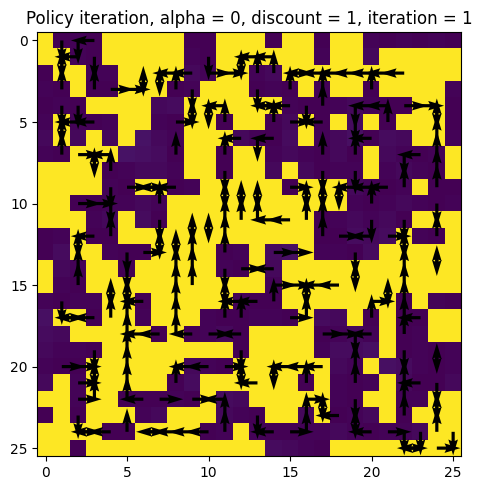

1


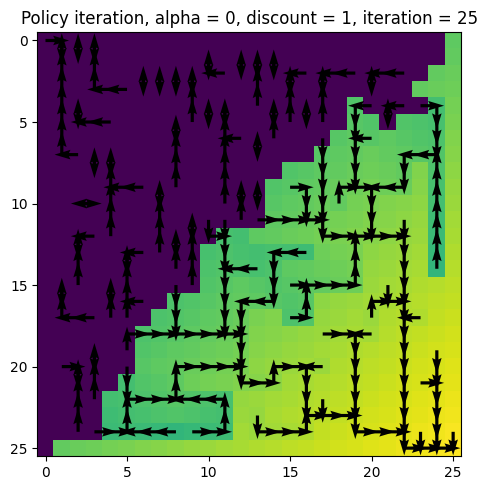

2


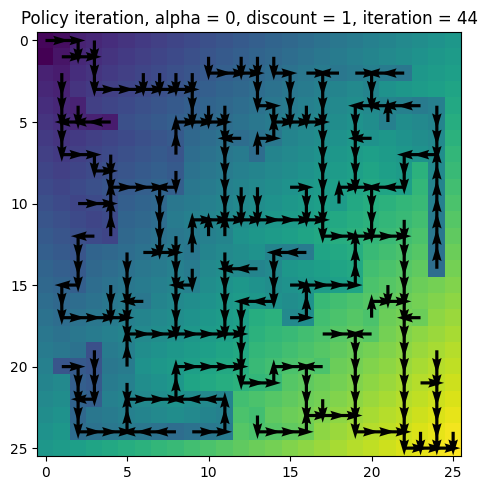

In [17]:
n_pol_eval = 100 #number of policy evalutions
max_it = 100
val2, pol2, pol_max_iter, time_taken = policy_iteration(S, A, Pr, alpha=0, discount=1, theta = 1e-6, n_eval=n_pol_eval, plot_enable = True, plot=[1, 25, 50, 100])
time_taken_normal = time_taken

<font color="green">
For the Policy Iteration above, as the number of Policy Iterations increase, the policy keeps getting better. And in the end, the policy wasn't changing as it already reached to most optimal value, so it converged and stopped at iteration 44 itself.

### II. Value Iteration

Run for 100 iterations. 
Plot the value function and the optimal policy, at iterations 1, 25, 50, 100.

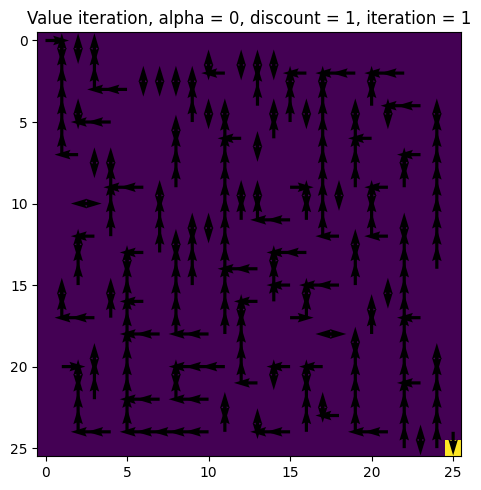

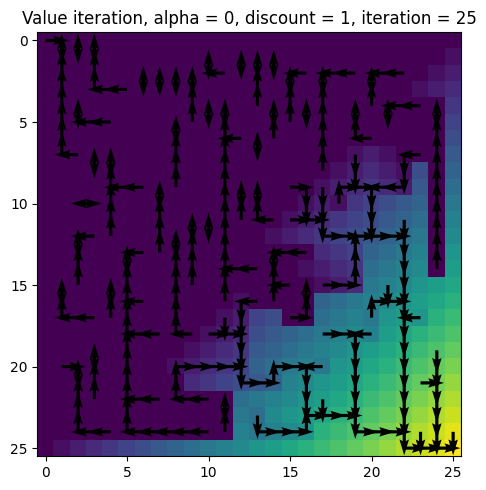

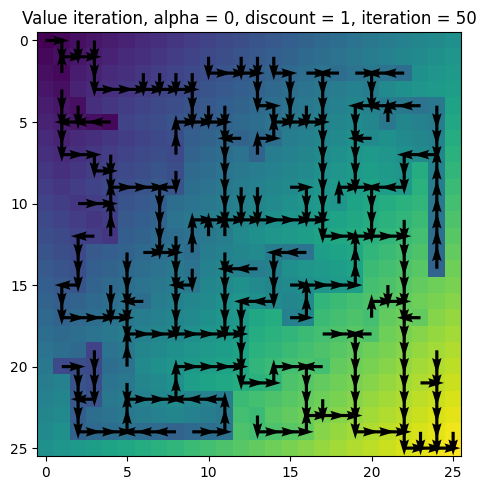

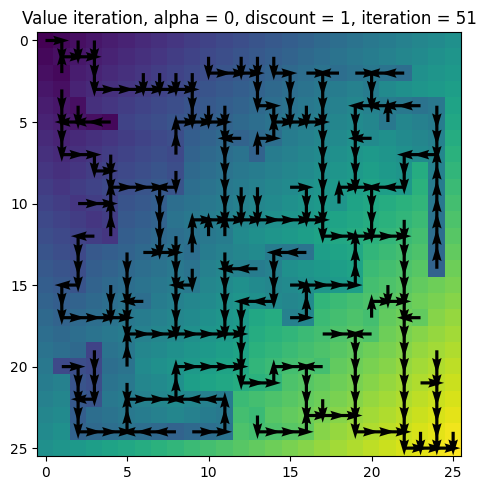

In [18]:

val1, pol1, val_max_iter, time_taken = value_iteration(S, A, Pr, alpha=0, discount=1, plot_enable=True, plot=[1, 25, 50, 100])


<font color="green">
For the Value Iteration above, as the number of Value Iterations increase, the policy keeps getting better. And in the end, the policy wasn't changing as it already reached to most optimal value, so it converged and stopped at iteration 51 itself.

Let's visualize these results

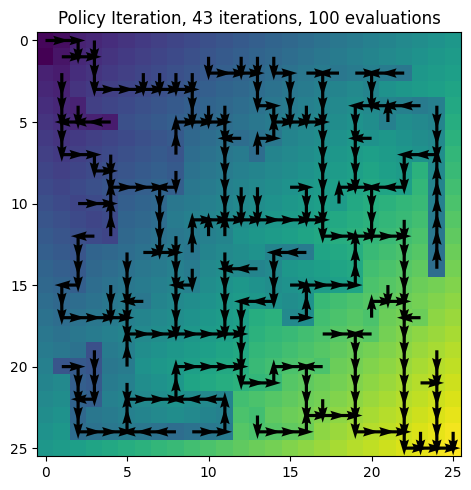

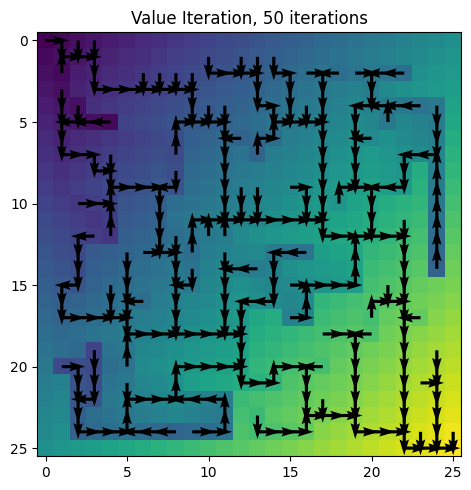

In [19]:
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
plot_value_grid(val2, pol2, msg='Policy Iteration, {} iterations, {} evaluations'.format(pol_max_iter, n_pol_eval))
# Plot for value iteration alpha = 0, 100 iterations
plot_value_grid(val1, pol1, msg='Value Iteration, {} iterations'.format(val_max_iter))

<font color="green">
Policy Iteration only took 43 Iterations which performed slightly better than Value Iteration which took 50 Iterations to converge. But both of them gave almost same optimal policy.

### III. Run Policy Iteration and Value Iteration for  five different discounted factors $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ and perform the following tasks

1. Explain the change in utilities for different $\gamma$
2. Explain the change in optimal policies for different $\gamma$

#### Policy iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

2


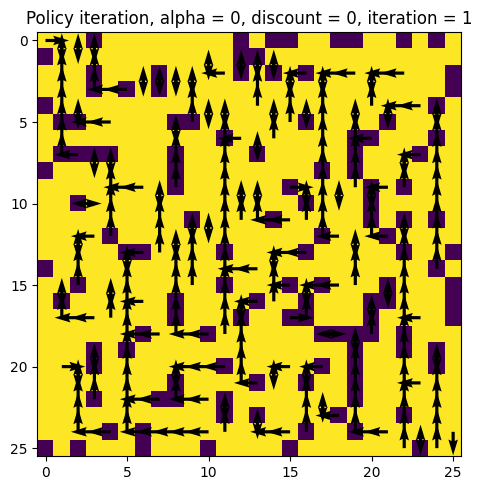

3
Policy iteration failed to converge for alpha = 0, discount = 0.1, iteration = 101


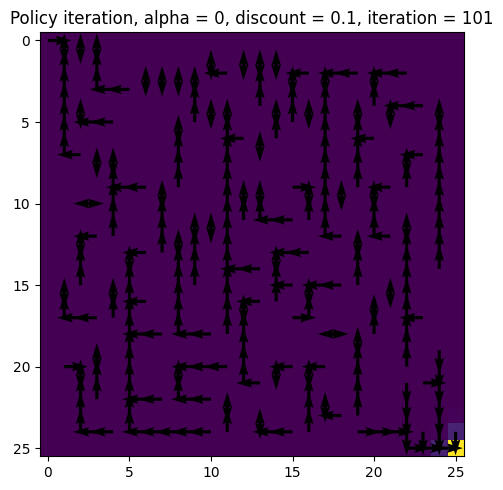

3
Policy iteration failed to converge for alpha = 0, discount = 0.4, iteration = 101


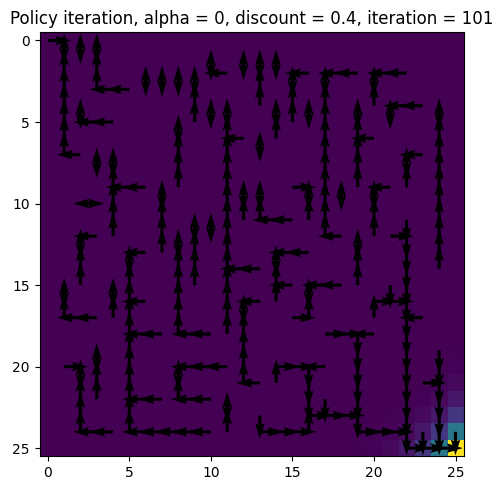

2


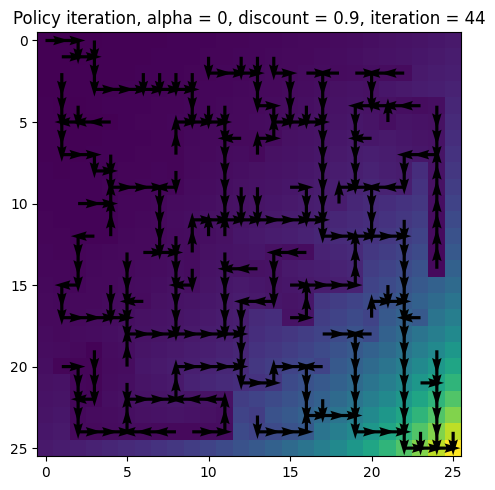

2


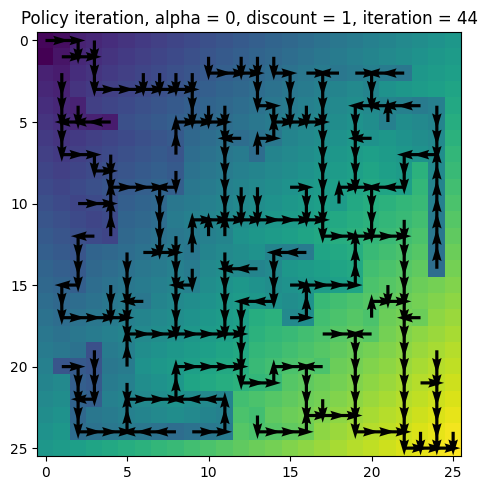

In [20]:
n_pol_eval = 100 #number of policy evalutions
pol_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :  
    val2, pol2, pol_max_iter, comp_time = policy_iteration(S, A, Pr, alpha=0, discount=gamma, theta=1e-6, n_eval=n_pol_eval, plot_enable = True)
    pol_time_list.append(comp_time)
    plt.pause(0.1)

<font color="green">
Observations for Policy Iteration with different $\gamma$

1. Change in utilities for different $\gamma$

    - For $\gamma$ = 0 , the immediate reward an agent receives upon taking an action in a particular state does not depend on the future expected reward at all. Policy Iteration converges just after one iteration with bad result.

    - For $\gamma$ = 0.1 , the utility function depends on the future expected reward but the impact is very less. The result was not great even though Policy Iteration ran for 100 Iterations and stopped at max iterations. 

    - For $\gamma$ = 0.4 , the utility function depends on the future expected reward more compared to previous case. So we got better result towards GOAL state.

    - For $\gamma$ = 0.9, the utility function depends on the future expected reward. Policy Iteration converged in 44 Iterations with good result. 

    - For $\gamma$ = 1 , the utility function depends on the future expected reward. Policy Iteration converged in 44 Iterations same as previous case.

2. Explain the change in optimal policies for different $\gamma$

    - For $\gamma$ = 0 , the optimal policy is not great and Policy Iteration converges just after one iteration as there is no improvement in the policy. 

    - For $\gamma$ = 0.1 , here also the optimal policy is not great even after Policy Iteration ran for 100 Iterations and stopped at max iterations. 

    - For $\gamma$ = 0.4 , here also the optimal policy is not great even after Policy Iteration ran for 100 Iterations and stopped at max iterations. But the policy at the states close to GOAL state got better. compared to when $\gamma$ = 0.1 but policy everywhere else is still not great. 

    - For $\gamma$ = 0.9, the optimal policy got better and the Policy Iteration converged in 44 Iterations.

    - For $\gamma$ = 1 , the optimal policy got better and the Policy Iteration converged in 44 Iterations same as the previous case.

#### Value iteration for 𝛾∈{0,0.1,0.4,0.9,1} :

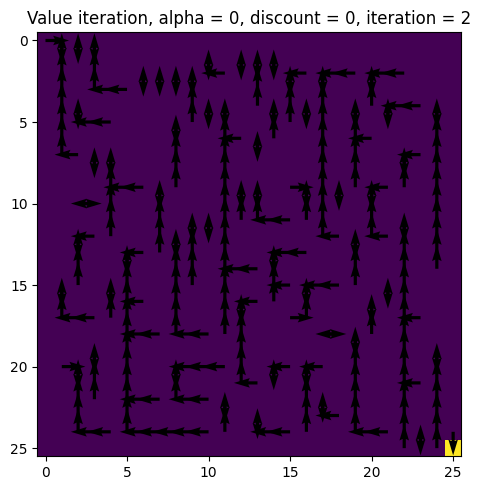

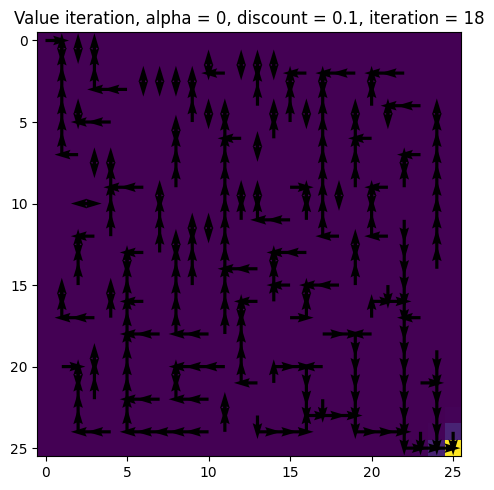

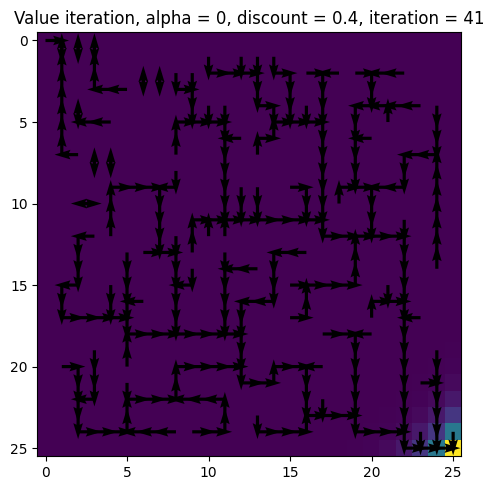

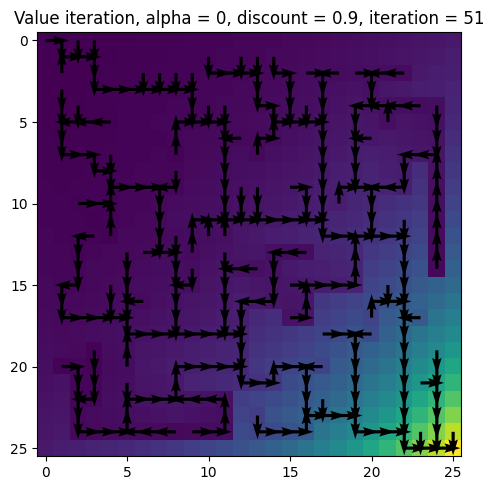

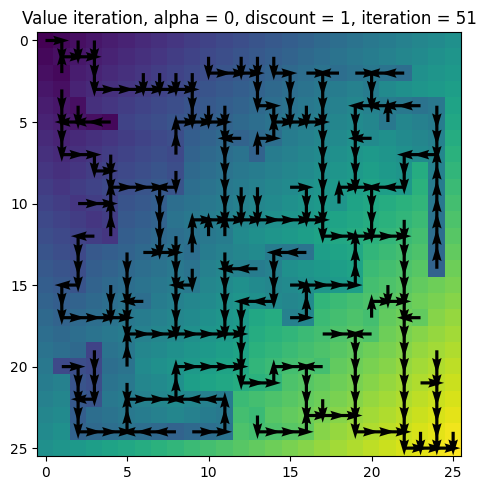

In [21]:
n_pol_eval = 100 #number of policy evalutions
val_time_list = []
for gamma in [0,0.1,0.4,0.9,1] :
    val1, pol1, val_max_iter, comp_time = value_iteration(S, A, Pr, alpha=0, discount=gamma, plot_enable=True, plot=None)
    val_time_list.append(comp_time)
    plt.pause(0.1)

#### Your explanations:

<font color="green">
Observations for Value Iteration with different $\gamma$

1. Change in utilities for different $\gamma$
    - For $\gamma$ = 0 , the immediate reward an agent receives upon taking an action in a particular state does not depend on the future expected reward at all. Value Iteration converges just after two iteration and result is not good.

    - For $\gamma$ = 0.1 , the utility function depends on the future expected reward but the impact is very less. The result was not great even though Value Iteration ran for 18 Iterations and converged as there is no more improvement in policy. The optimal policy for states close to GOAL seems correct but for every other state it is wrong.  It took 18 iterations to converge.

    - For $\gamma$ = 0.4 , the utility function depends on the future expected reward more compared to previous case. So we got better result towards GOAL state. But for states close to START state, it didn't perform well.It took 41 iterations to converge.

    - For $\gamma$ = 0.9, the utility function depends on the future expected reward. Value Iteration converged in 51 Iterations. 

    - For $\gamma$ = 1 , the utility function depends on the future expected reward. Value Iteration converged in 51 Iterations same as previous state.

2. Explain the change in optimal policies for different $\gamma$

    - For $\gamma$ = 0 , the optimal policy is not great and Value Iteration converges just after two iteration as there is no improvement in the policy. 

    - For $\gamma$ = 0.1 , here also the optimal policy is not great even after Value Iteration ran for 18 Iterations before it converged. The optimal policy for states close to GOAL were correct but for all other states, It dosen't look correct. 

    - For $\gamma$ = 0.4 , here also the optimal policy is not great even after Value Iteration ran for 41 Iterations before it converged due to no change in policy . But the optimal policy got better for all states except for states close to START state.

    - For $\gamma$ = 0.9, the optimal policy got better and the Value Iteration converged in 51 Iterations.

    - For $\gamma$ = 1 , the optimal policy got better and the Value Iteration converged in 51 Iterations same as previous state.
    

### IV. Plot $\gamma$ VS computational time for the given $\gamma$ 's in Task 3:

#### 𝛾 VS computational time for Policy iteration :

Text(0.5, 1.0, 'Discount VS Computational time for Policy iteration')

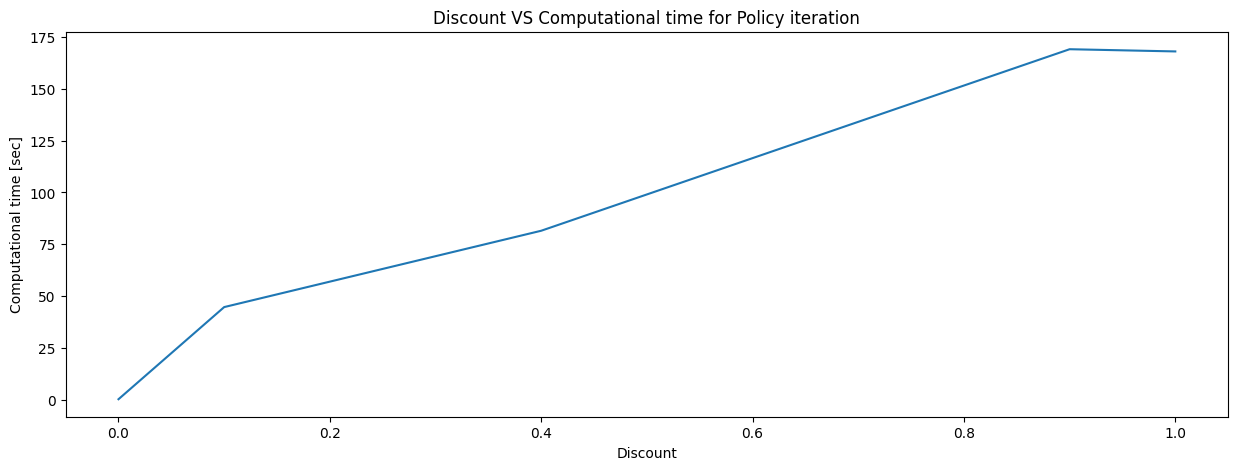

In [22]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], pol_time_list)
plt.title('Discount VS Computational time for Policy iteration')

#### 𝛾 VS computational time for Value iteration :

Text(0.5, 1.0, 'Discount VS Computational time for Value iteration')

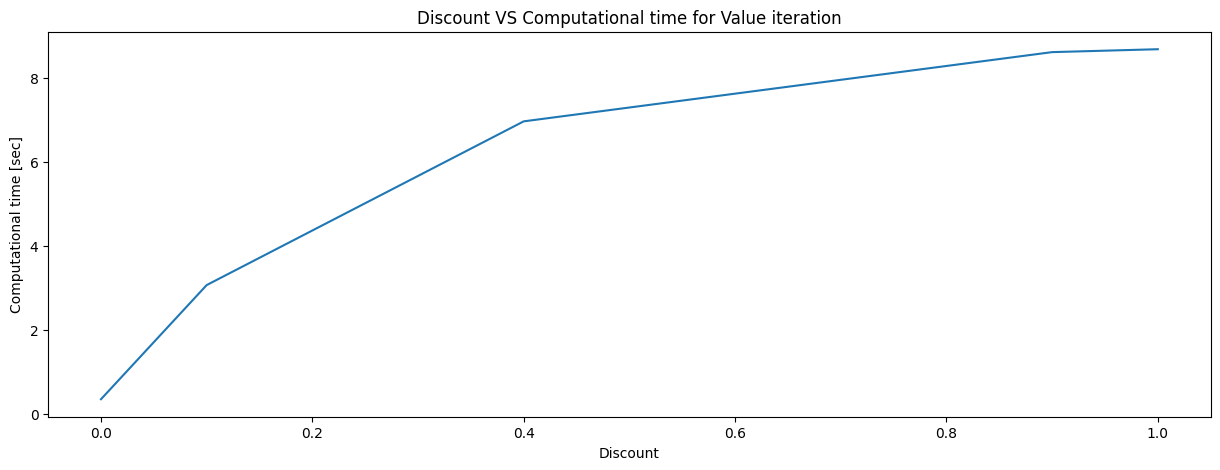

In [23]:
fig = plt.figure(figsize=(15,5))

plt.xlabel('Discount')
plt.ylabel('Computational time [sec]')
plt.plot([0,0.1,0.4,0.9,1], val_time_list)
plt.title('Discount VS Computational time for Value iteration')

<font color="Green">

- A simple change is that, more discount allows for the algorithm to consider 2 things, more weightage on future rewards and more number of future transitions actually being consired.

- The given times are for computational times for the policy iteration to converge, irrespective of it the problem is solved or not.

- For both model free control algorithms above:
    - With lower discount values, the algorithm doesn't focus on future that much, thus leading to not optimal solutions and no improvement further down the line such that the algorithm stagnates.
    - With higher discount values, the algorithm keeps on improving the policy and the value function, thus leading to optimal solutions and convergence, but taking more time for computation.


### B. Repeat Value and Policy iteration for 10, 20 and 100 iterations with $\alpha \in \{0.2, 0.8\}$

#### I. Policy Iteration 

1


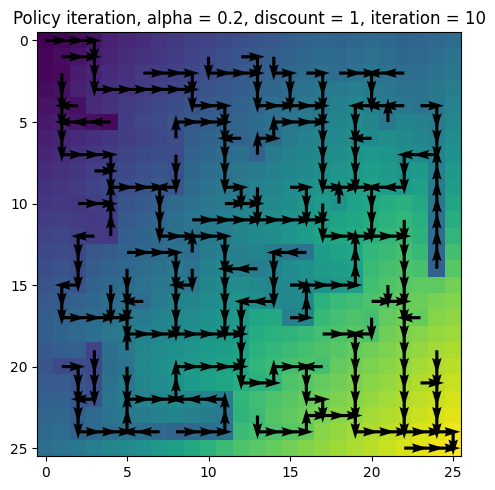

1


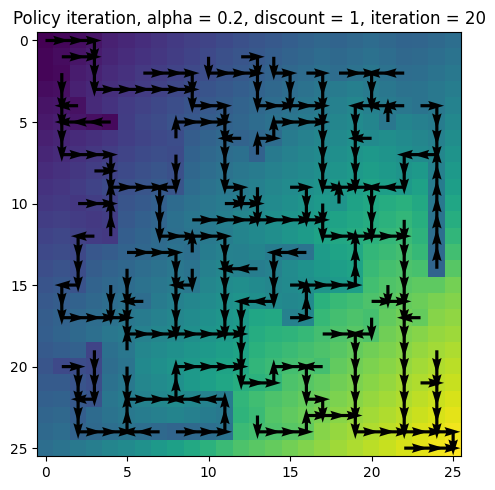

1


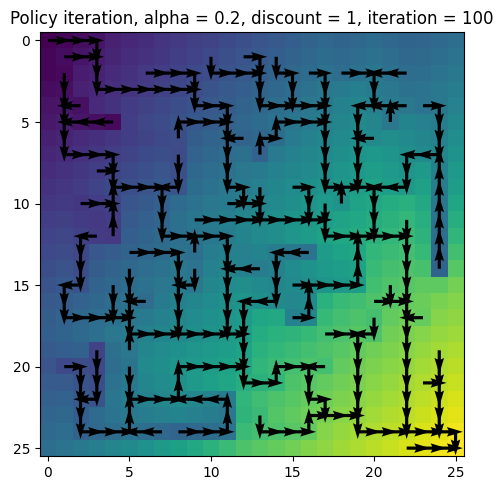

3
Policy iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


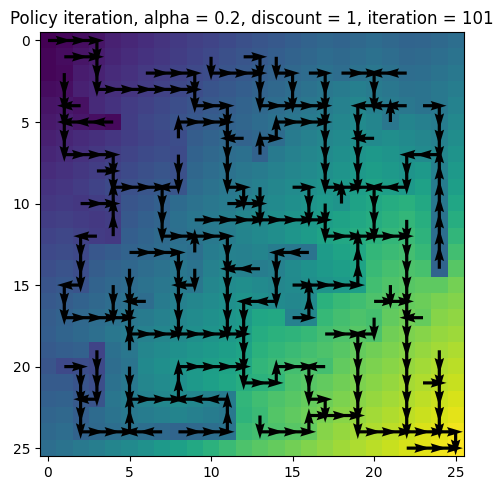

1


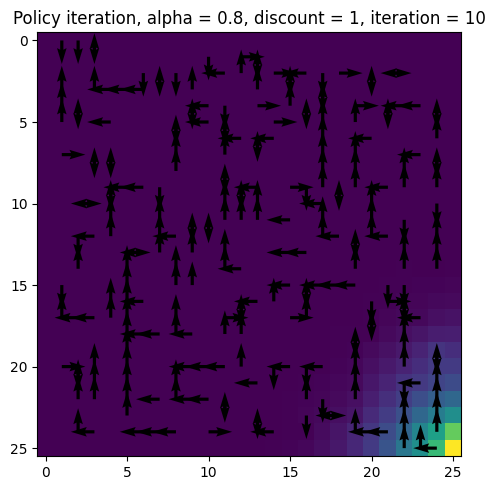

1


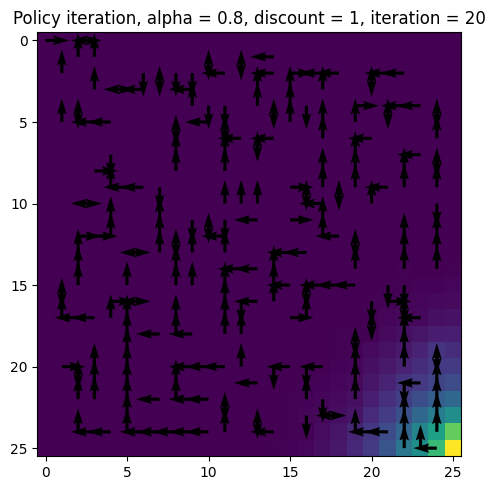

1


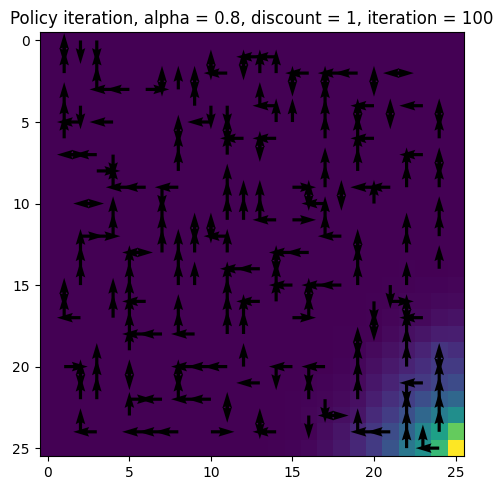

3
Policy iteration failed to converge for alpha = 0.8, discount = 1, iteration = 101


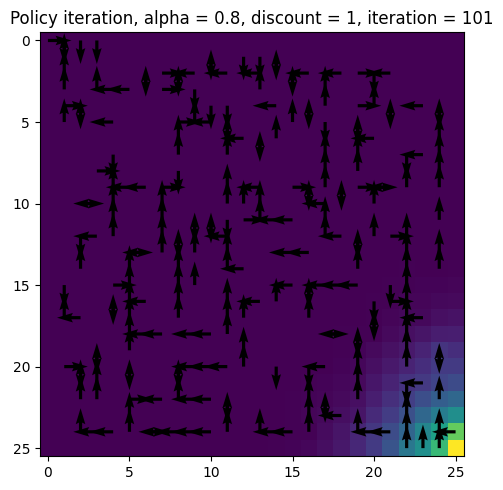

In [24]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, pol_iter, time_taken = policy_iteration(S, A, Pr, alpha=alpha, discount = 1, theta=1e-6, n_eval=100, plot_enable = True, plot=[10, 20, 100])
    

#### II. Value Iteration

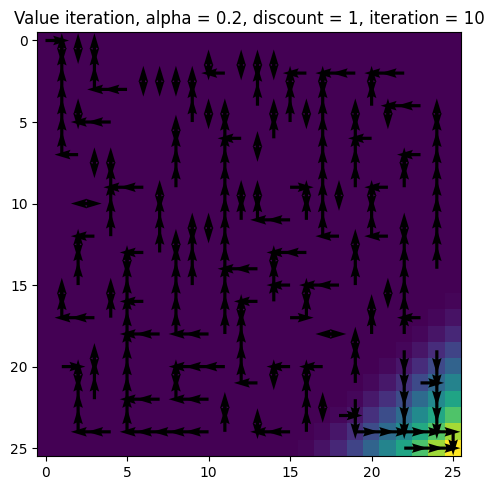

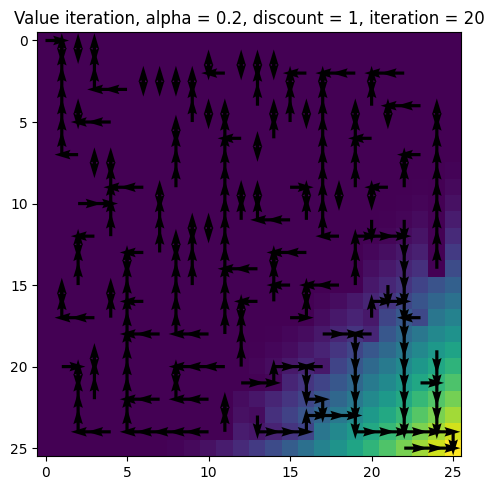

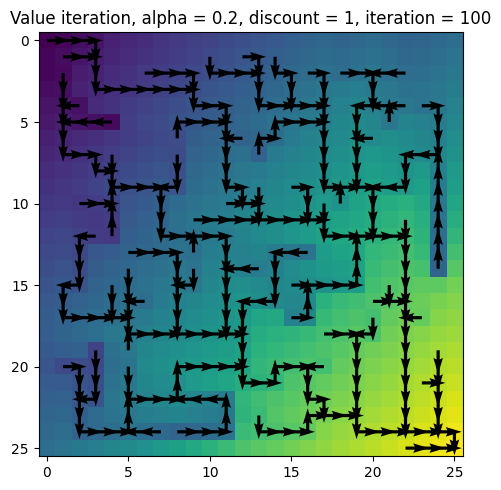

Value iteration failed to converge for alpha = 0.2, discount = 1, iteration = 101


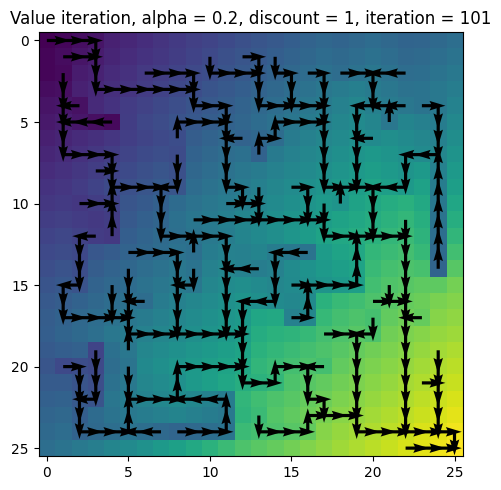

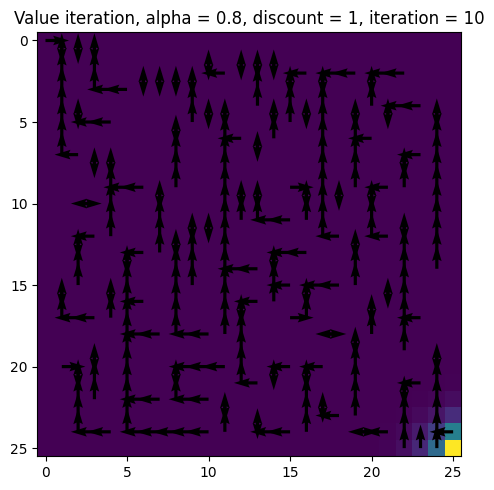

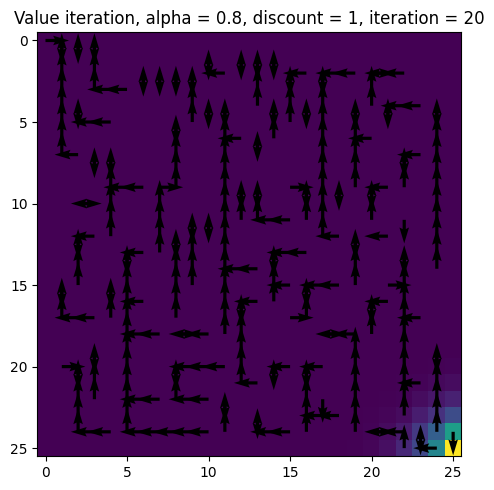

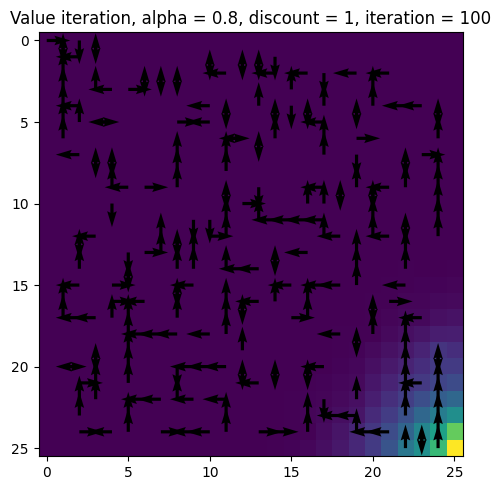

Value iteration failed to converge for alpha = 0.8, discount = 1, iteration = 101


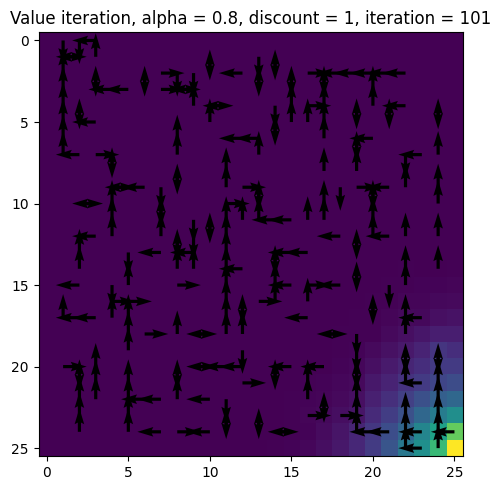

In [25]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, val_iter, comp_time = value_iteration(S, A, Pr, alpha = alpha, discount = 1, plot_enable=True, plot=[10, 20, 100])
    

**Summarize insights and your observations in Question B-I and B-II** 

<font color="Green">

- First, comparing across different alpha values 0.2 and 0.8, both did not converge completely because of being a slightly noisy environments.
    - Alpha 0.2 is very similar to alpha 0, but it is slightly noisy. The values are similar, and its a few actions shy of the best actions, which may be solved with more iterations.
    - Alpha 0.8 on the other hand is a highly noisy environment, where it showed no signs of convergence even after 100 iterations. The values and actions are very different than its optimal counterparts.
- Now comparing across value iteration and policy iteration in general, the values and actions are very similar across both methods. Except the farther away from the goal, the actions from policy and value iteration are a little different, but both optimal in their own right.

### C. Explain (up to 5 sentences) the differences between the approaches in HW1 (search, A*) and the approaches in the current assignment (MDP/Value/Policy) 

<font color="green">

1. Objective: A* is like a search algorithm used to find the shortest path between a start and goal nodes in a graph, while MDP is a framework used to model decision-making in a **stochastic environment over time**, aiming to find the optimal policy to maximize expected rewards.

2. Nature of Problem: In A* we can only model deterministic, fully observable environments where the entire state space is known, whereas MDP can be used in partially observable, stochastic environments where the outcomes of actions are uncertain.

3. Information Requirement: A* requires knowledge of the entire state space and the cost of moving between states, while MDP requires a bit more, knowledge of state space, possible actions in each state, probabilities of transitioning between states based on actions, and rewards associated.

4. Optimization: A* decision focuses on a heuristic function, while MDP is focused on finding the optimal policy that dictates the best action to get maximum reward over time. Immediate rewards vs long-term rewards.

5. Temporal Aspect: A* operates in a single-shot manner, finding the optimal path once, while MDP considers the long-term consequences of actions, taking into account the cumulative rewards over time.

## <h1><center> Part-2 </center></h1>

#### <h1><center> Utility functions to be implemented / PSEUDOCODE </center></h1>

Action space: Same as Part-1.
<br>
State space: Use the same maze as Part-1. You can use the get_maze() function from Part-1.
<br><br>
dS - size of the maze with dimensions: dS x dS 
<br>
dA - number of actions
<br>
Goal - goal state.
<br><br>

PSEUDOCODE: function validState(s) =  returns true if (state, s, is within the maze boundaries) AND (s is NOT in the obstacles)

PSEUDOCODE: function BuildMaze(dS, dA, Goal):
<br>

	# dynamics tensor with dimensions: |dS| x |dS| x |dA| x |dS| x |dS| x 1, where the 
	# dimensions are S₁, S₂, A, S₁′, S₂′. e.g., S₂ is the second coordinate of the current state, and S₁′ is the first coordinate of the state at the next time step. 
	Ps′_sa = zeros(dS, dS, dA, dS, dS, 1)

	# the reward tensor with the same dimension as the dynamics
	# reward is 0 at the Goal state, -10000 if agent hits the wall, and -1 elsewhere.
	Rs′sa  = -ones(dS, dS, dA, dS, dS, 1)

	# iterate over the valid states
	for s in filter(validState, (x->x.I).(CartesianIndices((dS, dS))))
		if s ∈ Goal
			Ps′_sa[s..., :, s...] .= 1.0 # all the actions get prob 1 at the goal 
			Rs′sa[s..., :, s...]  .= 0.0 # all the actions get reward 0
			continue
		end

		for a in Actions # the same action set at each state 
			# if "next state is valid" move to it, otherwise stay at place 
			s′ = validState(s .+ a[2]) ? s .+ a[2] : s 
			Ps′_sa[s..., a[1], s′...] = 1.0
		end 
	end
	"sanity test:" forall a, s : sum_s′ Ps′_sa = 1 
	return Ps′_sa, Rs′sa
end


#### <h1><center> TASKS </center></h1>

### Placeholder for the definition of global variables, functions, etc

In [26]:
# State Space

S=get_maze("my_maze.txt")  
START = (0, 0) # starting from TOP LEFT so, changing (1, 1) to (0, 0)
GOAL = (25,25)

A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]

A = np.array(A)
GRID_SIZE = len(S)
# goal state
S[GOAL] = 3
# Noise
ALPHA = [0.2, 0.8]

max_it = 100

In [27]:
def build_maze(S, A, alpha):
    Psnext_sa = np.zeros(shape=(GRID_SIZE, GRID_SIZE, len(A), GRID_SIZE, GRID_SIZE, 1))
    Rsa = -np.ones(shape=(GRID_SIZE, GRID_SIZE, len(A), 1, 1, 1))

    def out_of_bounds(s):
        if min(s) < 0 or max(s) >= GRID_SIZE or S[s] == 1:
            return True
        return False
    
    def assign_rewards_direct(s1, s2, a):
        if out_of_bounds(s_next_calc((s1, s2), a, return_actual=True)):
            return -1000
        if (s1, s2) == GOAL:
            return 0
        return -1
    
    def get_state_transitions(s, return_actual=False):
        actual_states =  [s_next_calc(s, _a, return_actual=True) for _a in range(len(A))]
        if return_actual:
            return actual_states
        corrected_states = [state if not out_of_bounds(state) else s for state in actual_states]
        return corrected_states
    
    def assign_transition_probs(s1, s2, a, alpha):
        sxs = np.zeros((GRID_SIZE, GRID_SIZE))
        if (s1, s2) == GOAL:
            return sxs
        states_transition = get_state_transitions((s1, s2), return_actual=False)
        x, y = s_next_calc((s1, s2), a, return_actual=False)
        sxs[x][y] += 1-alpha # main action
        states_transition.remove((x, y))
        for (x, y) in states_transition:
            sxs[x][y] += alpha/4 # all other actions
        return sxs
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            for a in range(len(A)):
                if S[i][j] == 1:
                    continue
                Psnext_sa[i][j][a] = np.expand_dims(assign_transition_probs(i, j, a, alpha), axis=-1)
                Rsa[i][j][a] = assign_rewards_direct(i, j, a)
    return Psnext_sa, Rsa

Psnext_sa, Rsa = build_maze(S, A, 0.2)

Below, Transition probabilities for all valid states and its subsequent actions add up to 1 except for the goal state and obstacle states.

In [28]:
# check if transition for all actions except final add up to 1
Psnext_sa.sum(axis=(3, 4))

array([[[[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        ...,

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        ...,

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],

In [29]:
def plot_value_grid_vectorised(V, policy, msg):
    V = V.squeeze()
    policy = np.argmax(policy.squeeze(), axis=2).squeeze()
    plot_value_grid(V, policy, msg)

### Task 1 ###
Build your maze and visualize the maze layout on 2D plot.

In [30]:
Psnext_sa, Rsa = build_maze(S, A, 0)

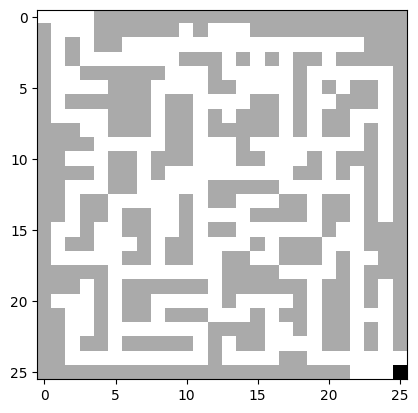

In [31]:
plt.imshow(S, cmap='binary')

### Task 2 ###
Implement the Policy Evaluation (PE) algorithm for a deterministic policy, π. 
<br>
The dimensions of the policy π[a | s] are |dS| x |dS| x |dA| x 1 x 1 x 1.
<br>
There is a single possible action at every state. 
<br>
E.g., π[UP | some_state] = [1, 0, 0, 0, 0], see 'Actions' above. 
<br>
E.g., π[Stay | another_state] = [0, 0, 0, 0, 1], see 'Actions' above. 
<br><br>
Evaluate a random deterministic policy, π.  Plot Value of a random policy on 2D plot. 
<br><br>
Instructions:
<br>
The policy is stationary, which means π[a′ | s′] is permute_dimensions(π[a | s], dim1->dim4, dim2->dim5, dim3->dim6)
<br>
Use broadcasting '.*', e.g.,
<br>
p(s′ a′ | s, a) = π[a′|s′] .* p(s′ | s, a)
<br>
sum_s′p(s′ | s, π[a|s]) .* V[s′], where V[s′] is the value of the next state with dimensions 1 x 1 x 1 x dS x dS x 1.
<br>
The value of the current state has dimensions dS x dS x 1 x 1 x 1 x 1. 
"V of the next state" is permute_dimensions("V of the current state", dims1->dims4, dims2->dims5)

In [32]:
def policy_evaluation_vectorized(policy, Psnext_sa, Rsa, discount, theta, ctr):
    V = np.zeros((GRID_SIZE, GRID_SIZE, 1, 1, 1, 1), dtype=np.float64)
    delta = 0
    for _ in range(ctr):
        V_prev = V.copy()
        Vsnext_sa = einops.rearrange(V_prev, "S1 S2 1 1 1 1 -> 1 1 1 S1 S2 1")
        Qsa = Rsa + discount * np.sum(Psnext_sa * Vsnext_sa, axis=(3, 4), keepdims=True)
        V = np.sum(policy * Qsa, axis=(2), keepdims=True)
        delta = max(delta, np.max(np.abs(V - V_prev)))
        if delta < theta:
            break
    return V, delta

<font color='Green'>
Used for loops above only to implement different iterations of the policy evaluation algorithm.

In [33]:
np.random.seed(42)
random_policy = np.eye(len(A))[np.random.choice(5, GRID_SIZE*GRID_SIZE)].reshape((GRID_SIZE, GRID_SIZE, len(A), 1, 1, 1))
V, delta = policy_evaluation_vectorized(random_policy, Psnext_sa, Rsa, discount=1, theta=1e-6, ctr=100)

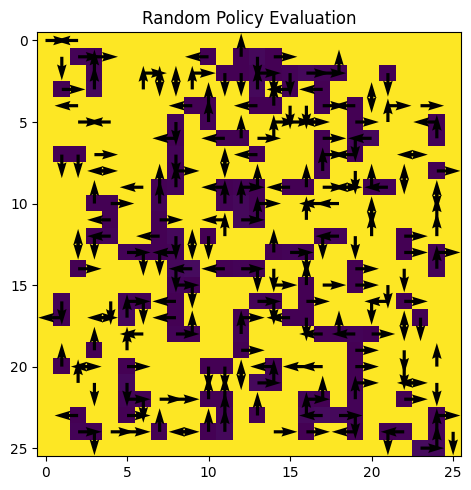

In [34]:
plot_value_grid_vectorised(V, random_policy, "Random Policy Evaluation")

### Task 3 ###
Repeat Task 2 with manually setting the optimal actions in the radius of 2 states from the goal state.
Explain your observations.

<font color="Green">
In my particular maze, the states which are in 2 radius to goal i.e 2 steps away from goal:

- (24, 25) -- best action is DOWN -- A[1]

- (24, 24) -- best action is RIGHT -- A[3]

- (25, 24) -- best action is RIGHT -- A[3]

- (23, 25) -- best action is RIGHT -- A[1]

Set the random seed for reproducible results down the below

In [35]:
np.random.seed(42)
random_policy = np.eye(len(A))[np.random.choice(5, GRID_SIZE*GRID_SIZE)].reshape((GRID_SIZE, GRID_SIZE, len(A), 1, 1, 1))

# manually set 
random_policy[24][25] = np.zeros_like(random_policy[24][25])
random_policy[24][24] = np.zeros_like(random_policy[24][24])
random_policy[25][24] = np.zeros_like(random_policy[25][24])
random_policy[23][25] = np.zeros_like(random_policy[23][25])

random_policy[24][25][1] = 1 # down
random_policy[24][24][3] = 1 # right
random_policy[25][24][3] = 1 # right
random_policy[23][25][3] = 1 # right



In [36]:
V, delta = policy_evaluation_vectorized(random_policy, Psnext_sa, Rsa, discount=1, theta=1e-6, ctr=100)

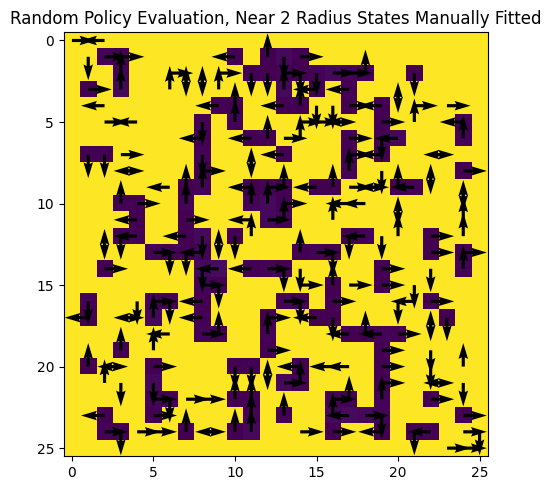

In [37]:
plot_value_grid_vectorised(V, random_policy, "Random Policy Evaluation, Near 2 Radius States Manually Fitted")

#### Your observations:

<font color='Green'>
Here, we set the above described states to the best action possible.

The difference is that, clearly, the value of these states that are modified improved significantly, clearly shown by the difference in the scale of color in those regions.


### Task 4 ###
Implement the Policy Improvement (PI) Algorithm, and find the optimal policy π*.
Visualize the optimal value function, V_i, on a 2D plot at 3 different iterations, i, of PI.
Explain your observations.

In [38]:
def policy_improvement_vectorized(V, Psnext_sa, Rsa, discount, old_policy):
    Vsnext_sa = einops.rearrange(V, "S1 S2 1 1 1 1 -> 1 1 1 S1 S2 1")
    
    Qsa = Rsa + discount * np.sum(Psnext_sa * Vsnext_sa, axis=(3, 4), keepdims=True)

    
    new_policy = np.zeros_like(old_policy)
    x_indices, y_indices = np.indices((GRID_SIZE, GRID_SIZE))
    
    new_policy[x_indices, y_indices, np.argmax(Qsa, axis=2).squeeze()] = 1

    policy_stable = np.array_equal(old_policy, new_policy)
    
    return new_policy, policy_stable

In [39]:
def policy_iteration_vectorised(A, Psnext_sa, Rsa, alpha, discount, theta, n_eval, plot_enable, plot=None):
    """
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise 
    :param float discount: discount factor
    :param float theta: tolerance, which determines when to end iterations
    :param int n_eval: number of evaluations
    :param plot: list of iteration numbers to plot
    """
    
    epsilon = 0
    
    # For Task 4 ######
    start_time = 0
    end_time = 0
    time = 0
    total_time = 0
    ###################
    
    plt.ion()
    policy = np.eye(len(A))[np.random.choice(5, GRID_SIZE*GRID_SIZE)].reshape((GRID_SIZE, GRID_SIZE, len(A), 1, 1, 1))
    count=0
    
    while True:
                
        start_time = datetime.datetime.now() # For Task 4
        
        V, delta = policy_evaluation_vectorized(policy, Psnext_sa, Rsa, discount, theta, n_eval)
        policy , policy_stable = policy_improvement_vectorized(V, Psnext_sa, Rsa, discount, policy)


        # For Task 4
        end_time = datetime.datetime.now()
        time = (end_time - start_time).total_seconds() # calculate time taken [seconds] for one iteration
        total_time += time
      

        # plot intermediate result
        if (plot and count+1 in plot) and plot_enable:
            print(1)
            plot_value_grid_vectorised(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
        
        if delta == 0:
            print(2)
            if plot_enable :
                plot_value_grid_vectorised(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
                
        if (delta > 0 and delta<=epsilon) or count==max_it or policy_stable:   
            print(3) 
            if(count == max_it):
                print('Policy iteration failed to converge for alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            if(plot_enable):
                 plot_value_grid_vectorised(V, policy, msg='Policy iteration, alpha = {}, discount = {}, iteration = {}'.format(alpha, discount, count+1))
            break
        count=count+1

    return V, policy, count, total_time, delta


1


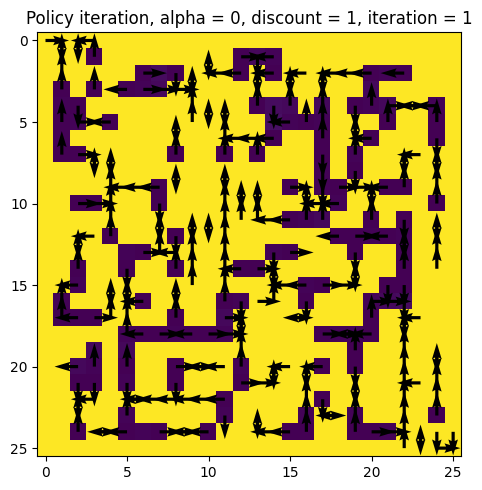

1


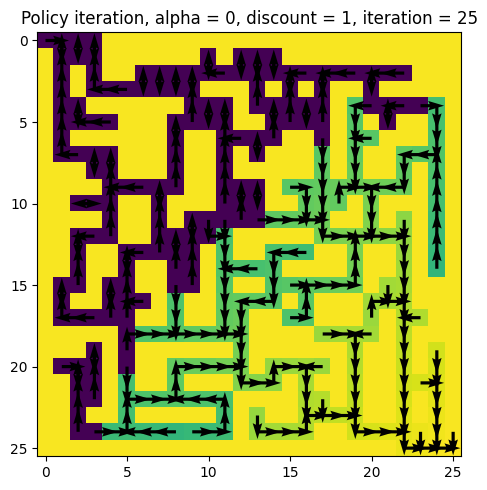

3


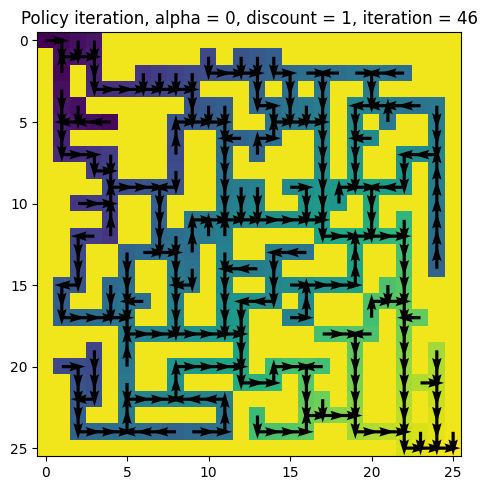

In [40]:
valvec, polvec, pol_max_iter, time_taken_vec, delta_vec = policy_iteration_vectorised(A, Psnext_sa, Rsa, alpha=0, discount=1, theta = 1e-6, n_eval=100, plot_enable = True, plot=[1, 25, 50, 100])

In [41]:
print("Time taken for vectorised policy iteration to converge : ", time_taken_vec)
print("Time take for normal policy iteration to converge : ", time_taken_normal)

Time taken for vectorised policy iteration to converge :  13.167406999999999
Time take for normal policy iteration to converge :  169.45844599999995


#### Your observations:

<font color='green'>

- First, the time difference between policy iteration vectorised and normal is significant. The vectorised version is more than **11x** faster. (Tested on base M1 Pro macbook)

- As observed in the normal versions, the same phenomena is observed in vectorised versions.

- The values, (expected accumated reward from that state) are increasing as the iterations increase.

- The direction of this convergence is from the goal state as expected, because the states closer to the goal state have an easier time deciding the highest reward action rather than the states far from the goal state, which are blinded by the the wrong decisions of the subsequent states.

- At the end of 47 policy iterations, the algorithm converged and a quick manual check gave that every action it took could be the best possible action from that state to reach goal state.

- One interesting thing to note is that the normal one converged at 44 iterations and the vectorised version converged at 47. This could be because of the way the vectorised version is implemented. The data types used might be causing the difference in convergence.

- We tried this at 2 alpha values, 0 and 0.2. Works well for 0. But doesn't converge directly from 0.2. It may require a few more iterations. But the policy is almost similar to the one with alpha 0.

- Our experiments with alpha 0.8 didn't converge at all, we believe its due to too much noise in the system. 

In [42]:
print(datetime.datetime.now() - main_start_time)

0:25:25.751778
